# Problem
dataset: [Daily Electricity Price and Demand Data](https://www.kaggle.com/datasets/aramacus/electricity-demand-in-victoria-australia/data)

## Forecast Horizon
We forecast 3 day.

# Utilities
utility functions for statistical model

In [506]:
# import
import matplotlib.pyplot as plt
import pandas as pd
from darts.metrics import mse, mae
from datetime import timedelta

## Rolling Predict
Make rolling predict on (validation or test) and calculate mse and mae error

In [591]:
def rolling_pred(true_y, true_y_transformed, model, transformer_y, horizon, past_covariates, metric, refit=True, start=None):
    """
    :param true_y: Time series of true value with transformation
    :param true_y_transformed: Time series of true value without transformation
    :param model: trained darts model which predict transformed target value
    :param model: transformer applied to target value, must have .inverse_transform() method
    :param horizon: int
    :param past_covariates: Time series of covariates
    :return pred: rolling predictions which is transformed back to original scale
    :return score: list containing
    """

    # predict
    pred_scaled = model.historical_forecasts(series=true_y_transformed,
                                             forecast_horizon=horizon,
                                             past_covariates=past_covariates,
                                             retrain=refit,
                                             start=start)
    # inverse-transform to predicted target
    pred = transformer_y.inverse_transform(pred_scaled)

    # calculate mse and mae score
    score = model.backtest(series=true_y,
                           past_covariates=past_covariates,
                           historical_forecasts=pred,
                           forecast_horizon=horizon,
                           metric=metric,
                           retrain=refit)

    # return
    return pred, score

## Plot Rolling Prediction

In [630]:
# function for plotting
def plot_rolling_pred(true_value, prediction, name_model, name_set, legend_out):
    """
    plot rolling predictions and true values
    :param true_value: darts TimeSeries
    :param prediction: darts TimeSeries
    :param name_model: string, name of statistical model
    :param name_set: string, 'Validation', 'Training' or 'Test'
    :param legend_out: bool
    :return: None
    """
    # cast true value series to make the same length as prediction
    true_value = true_value.drop_before(prediction.start_time()-timedelta(days=1))


    # plot
    f, ax = plt.subplots(figsize=(10, 2))
    true_value.plot(label='True Value', ax=ax, alpha=0.5, linewidth=0.8, c='r')
    prediction.plot(label=name_model, ax=ax, alpha=0.5, linewidth=0.8, c='g')

    # adjust legend
    if legend_out:
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_ylabel('Demand(MWh)')

    ax.set_title(f'{name_model} on {name_set} Set')

## Add Scoring Metrics

In [571]:
# function to add metrics of a model to score dataframe

def add_score(score_dataframe, name_model, score):
    """
    function to add scoring metrics of a model to the score dataframe as one column. mse and mae is used here.
    :param score_dataframe: existed dataframe for score of each model
    :param name_model: name of model(column) in dataframe
    :param score: mse and mae score of model
    :return: dataframe of scoring metrics
    """
    score_dataframe[name_model] = score

    return score_dataframe

## Print ADF Results

In [456]:
# function to print results of statsmodels adfuller test
def print_adf(adfuller_result):
    """
    Take statsmodel adfuller() results and wrap it into dataframe for better viewing
    :param adfuller_result: output of adfuller()
    :return: None
    """

    dataframe_results = pd.Series(
        adfuller_result[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )


    for key, value in adfuller_result[4].items():
        dataframe_results["Critical Value (%s)" % key] = value

    print("Results of ADF Test:")
    print(dataframe_results)

## ADF Test

In [457]:
from statsmodels.tsa.stattools import adfuller

# function to print results
def adf_test(timeseries, reg='c'):
    """
    Take a pandas series, perform ADF test and print reuslts
    :param timeseries: Series
    :param reg: 'c', 't', 'ct', etc.
    :return: None
    """

    df_test = adfuller(timeseries, autolag="AIC", regression=reg)
    print_adf(df_test)

## KPSS Test

In [ ]:
from statsmodels.tsa.stattools import kpss

#  function to print reuslts
def kpss_test(timeseries):
    """
    function to do kpss test on pandas Series and print results as a dataframe
    :param timeseries:
    :return:
    """
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

# Data Preprocessing

## Load Data

In [2]:
# read data
data_raw = pd.read_csv('dataset/complete_dataset.csv')
data_raw.head()

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


In [3]:
# extract related variables
data_raw = data_raw.copy()[['date', 'demand', 'min_temperature', 'max_temperature',\
                            'solar_exposure', 'rainfall', 'school_day', 'holiday']]
data_raw.head()

,date,demand,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,15.0,22.0,30.7,0.0,N,N


## Clean Data

### Check datat

In [4]:
# check datatype
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             2106 non-null   object 
 1   demand           2106 non-null   float64
 2   min_temperature  2106 non-null   float64
 3   max_temperature  2106 non-null   float64
 4   solar_exposure   2105 non-null   float64
 5   rainfall         2103 non-null   float64
 6   school_day       2106 non-null   object 
 7   holiday          2106 non-null   object 
dtypes: float64(5), object(3)
memory usage: 131.8+ KB


In [5]:
# check NA values
data_raw.isna().sum()

date               0
demand             0
min_temperature    0
max_temperature    0
solar_exposure     1
rainfall           3
school_day         0
holiday            0
dtype: int64

In [6]:
# check 'float' column
data_raw[['school_day', 'holiday']].value_counts()

school_day  holiday
Y           N          1431
N           N           598
            Y            55
Y           Y            22
Name: count, dtype: int64

The following data issues should be solved:
* convert type to datetime
* fill NA

### Type Conversion

Convert time to DateTime

In [7]:
# convert column date to DateTime
data_raw.date = pd.to_datetime(data_raw.date)
data_raw.date

0      2015-01-01
1      2015-01-02
2      2015-01-03
3      2015-01-04
4      2015-01-05
          ...    
2101   2020-10-02
2102   2020-10-03
2103   2020-10-04
2104   2020-10-05
2105   2020-10-06
Name: date, Length: 2106, dtype: datetime64[ns]

Convert categorical to float. 'N' to 0 and 'Y' to 1

In [8]:
# convert column school_day and holiday
data_raw.school_day = pd.factorize(data_raw['school_day'])[0]
data_raw.holiday = pd.factorize(data_raw['holiday'])[0]
data_raw[['school_day', 'holiday']]

,school_day,holiday
0,0,0
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
2101,0,1
2102,0,1
2103,0,1
2104,0,1


### Fill NA
Fill NAN in `solar_exposure` and `rainfall` by polynomial interpolation.

In [9]:
# fill NA
data_raw[['solar_exposure', 'rainfall']] = data_raw[['solar_exposure', 'rainfall']].interpolate(method='polynomial', order=2)

In [10]:
# re-check NA
data_raw[['solar_exposure', 'rainfall']].isna().sum()

solar_exposure    0
rainfall          0
dtype: int64

### Reindex
make date-time as index

In [472]:
# re-index for simple plotting
data_clean = data_raw.copy()
data_clean.set_index('date', inplace=True)
data_clean.index.name= 'Date'

### Extract ymd
extract year, month, date, etc. from index and add as a column

In [473]:
# extract
data_clean['weekday_name'] = data_clean.index.day_name()
data_clean['weekday'] = data_clean.index.weekday
data_clean['week'] = data_clean.index.isocalendar().week
data_clean['day'] = data_clean.index.day
data_clean['date'] = data_clean.index.date
data_clean['month'] = data_clean.index.month
data_clean['month_name'] = data_clean.index.month_name()
data_clean['year'] = data_clean.index.year
data_clean['time_period'] = range(1, len(data_clean) + 1)

In [474]:
# check new columns
data_clean.iloc[:, -9:].head()

,weekday_name,weekday,week,day,date,month,month_name,year,time_period
Date,,,,,,,,,
2015-01-01,Thursday,3,1,1,2015-01-01,1,January,2015,1
2015-01-02,Friday,4,1,2,2015-01-02,1,January,2015,2
2015-01-03,Saturday,5,1,3,2015-01-03,1,January,2015,3
2015-01-04,Sunday,6,1,4,2015-01-04,1,January,2015,4
2015-01-05,Monday,0,2,5,2015-01-05,1,January,2015,5


### Merge temperature columns

In [475]:
# create a feature which is the mean of max and min temperature
data_clean['avg_temperature'] = data_clean[['max_temperature', 'min_temperature']].mean(axis=1)
data_clean.avg_temperature

Date
2015-01-01    20.10
2015-01-02    27.10
2015-01-03    29.10
2015-01-04    18.85
2015-01-05    18.50
              ...  
2020-10-02    19.40
2020-10-03    23.40
2020-10-04    21.50
2020-10-05    10.90
2020-10-06    10.75
Name: avg_temperature, Length: 2106, dtype: float64

## Visualization
Make plots to understand the time series.

### Daily Electricity Demand
Plot each day's demand.

Text(0, 0.5, 'Demand(MWh)')

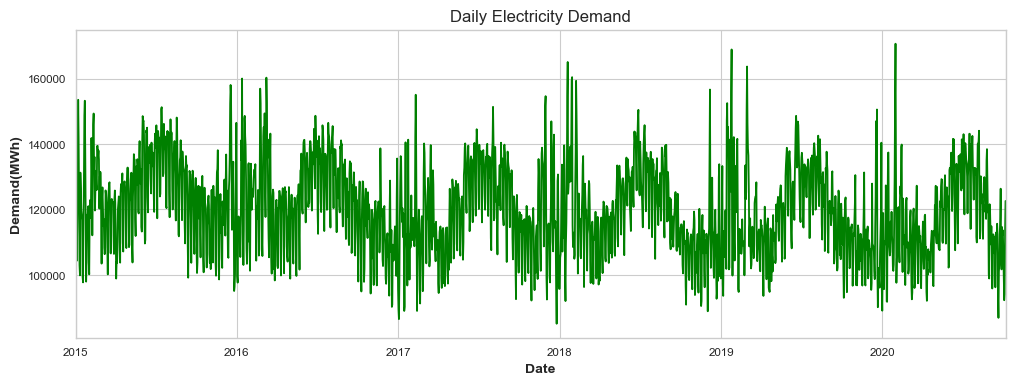

In [476]:
# view demand of all dates
f, ax = plt.subplots(figsize=(12, 4))
data_clean.demand.plot(c='g', ax=ax)
ax.set_title('Daily Electricity Demand')
ax.set_ylabel('Demand(MWh)')

### Rolling Average Plot
Plot the monthly demand to make it soomther

Text(0, 0.5, 'Demand(MWh)')

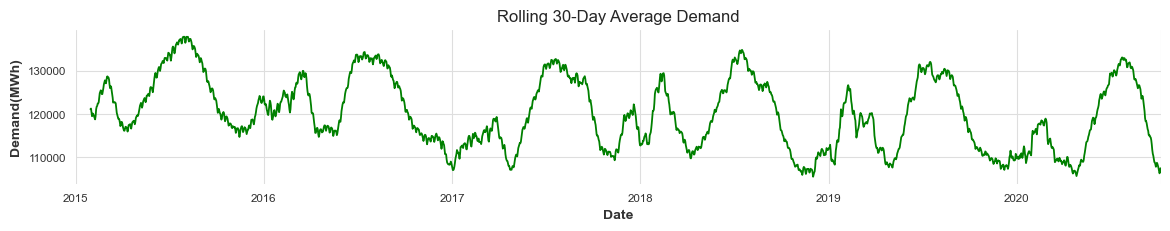

In [18]:
# monthly demand
ax = data_clean.demand.rolling(30).mean().plot(figsize=(14, 2), c='g')
ax.set_title('Rolling 30-Day Average Demand')
ax.set_ylabel('Demand(MWh)')

### Demand versus Weather
Visualize the relation between demand, temp and solar explosure

Text(0.5, 1, 'Electricity Demand versus Weather')

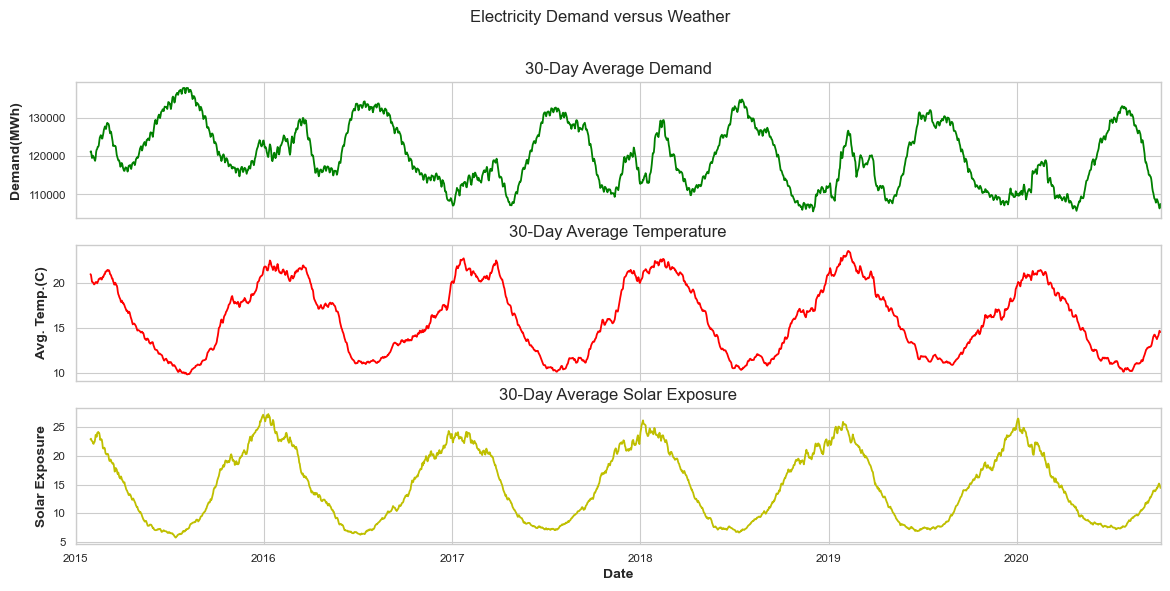

In [435]:
# make plot
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(14, 6), sharex=True)

# plot demand
data_clean.demand.rolling(30).mean().plot(kind='line', c='g', ax=ax[0])

# plot temperature
data_clean.avg_temperature.rolling(30).mean().plot(kind='line', c='r', ax=ax[1])

# plot sunshine
data_clean.solar_exposure.rolling(30).mean().plot(kind='line', c='y', ax=ax[2])

# adjust
ax[0].set_title('30-Day Average Demand')
ax[0].set_ylabel('Demand(MWh)')
ax[1].set_title('30-Day Average Temperature')
ax[1].set_ylabel('Avg. Temp.(C)')
ax[2].set_title('30-Day Average Solar Exposure')
ax[2].set_ylabel('Solar Exposure')
f.suptitle('Electricity Demand versus Weather', fontweight='regular', y=1)

### Seasonal plots


In [20]:
import pandas as pd
import seaborn as sns

# function to make seasonal plot of electricity usage
def seasonal_plot(df, col_season, col_x, col_to_plot):
    """
    Make seasonal plot from Pandas Dataframe
    :param df:
    :param col_season:
    :param col_x:
    :param col_to_plot:
    :return:
    """

    # pivot and plot
    f, ax = plt.subplots()
    df_pivot = pd.pivot_table(df, index=col_x, columns=col_season, values=[col_to_plot])
    df_pivot.plot(figsize=(8, 4), ax=ax)

    # adjust
    ax.set_ylabel('Demand(MWh)')
    ax.set_title('Seasonality Plot of ' + col_to_plot +' by ' + col_x)
    ax.legend(title=None)
    ax.set_xticks(df[col_x].unique())

    return df_pivot, ax

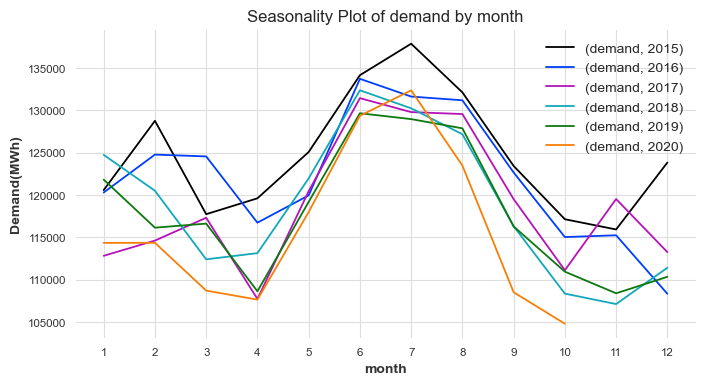

In [21]:
# Plot monthly seasonality
_, ax = seasonal_plot(data_clean, 'year', 'month', 'demand')

#  Data Preparation
## Load to darts
load the pandas dataframe into dart's format for time series data

Reference:
- [Time series in darts](https://unit8co.github.io/darts/userguide/timeseries.html?highlight=from_dataframe#multivariate-time-series-vs-multiple-time-series)

### All Variables
load all dataframe into darts

In [437]:
# load dataframe into darts
from darts import TimeSeries

# load Dataframe to darts as multivariate time series
ts_multi = TimeSeries.from_dataframe(data_clean,
                                     value_cols=['demand', 'min_temperature', 'max_temperature',\
                            'avg_temperature', 'solar_exposure', 'rainfall', 'school_day', 'holiday'])


### Electricity Demand
This is the target variable we want to predict.

In [438]:
# load demand to darts as uni-variate time series

ts_demand = TimeSeries.from_series(data_clean.demand)

In [439]:
# check uni-variate
ts_demand.is_univariate

True

### Extract Covariates
Extract weather time series as covariates to help forecasting.

In [440]:
# extract weather information
ts_weather = ts_multi[['avg_temperature', 'solar_exposure', 'rainfall']]
ts_weather.columns

Index(['avg_temperature', 'solar_exposure', 'rainfall'], dtype='object', name='component')

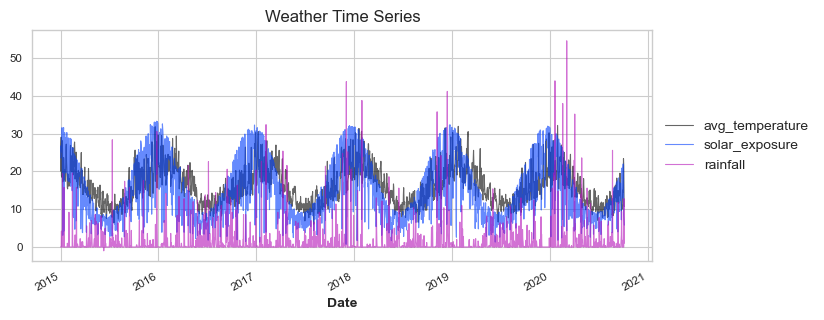

In [441]:
# plot weather seires

f, ax = plt.subplots(figsize=(10,3))
ts_weather.plot(ax=ax, alpha=0.6, linewidth=0.8)
ax.set_title('Weather Time Series')

# adjust legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Dtype for Performance
All numerical data type in darts are float64 or float32. Due to large amount of computation required for deep learning, all series will be casted to float32.

In [442]:
# first look at data type
print(ts_demand.dtype)
print(ts_weather.dtype)

float64
float64


In [443]:
# transform to float32
ts_demand = ts_demand.astype(np.float32)
ts_weather = ts_weather.astype(np.float32)

In [444]:
# recheck
print(ts_demand.dtype)
print(ts_weather.dtype)

float32
float32


## Split Data
Split data into train, validation and test set

### Split Electricity Demand

In [445]:
# take first 80% timestamp as train
ts_weather_train, ts_weather_oth = ts_weather.split_before(0.8)

# take 80%-90% as validation, and last 10% as test
ts_weather_val, ts_weather_test = ts_weather_oth.split_before(0.5)

### Split Covariates

In [446]:
# take first 80% timestamp as train
ts_demand_train, ts_demand_oth = ts_demand.split_before(0.8)

# take 80%-90% as validation, and last 10% as test
ts_demand_val, ts_demand_test = ts_demand_oth.split_before(0.5)

### Store dates
Store start and end dates of all sets, as well as the duration of all sets.


In [447]:
# store start date and end date of train, val and test set
train_start = ts_demand_val.start_time()
train_end = ts_demand_train.end_time()
val_start = ts_demand_val.start_time()
val_end = ts_demand_val.end_time()
test_start = ts_demand_test.start_time()
test_end = ts_demand_test.end_time()

In [449]:
# length of train, validaiton and test set
len_train = len(ts_demand_train)
len_val = len(ts_demand_val)
len_test = len(ts_demand_test)

## View Duration

Text(0, 0.5, 'Demand(MWh)')

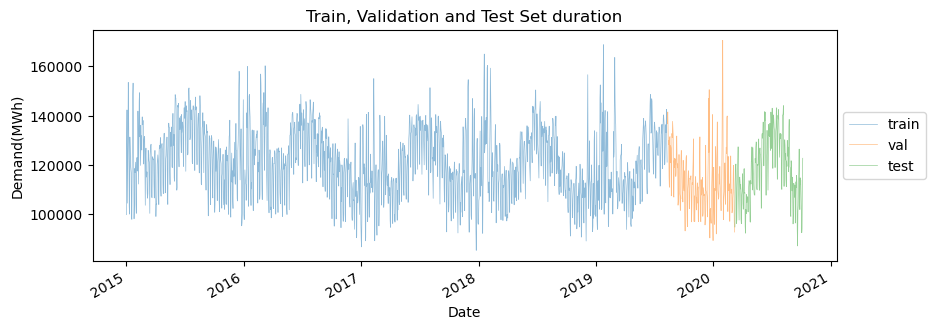

In [566]:
# view duration of train, validation and test set
f, ax = plt.subplots(figsize=(12, 3))

for data_series, name in zip([ts_demand_train, ts_demand_val, ts_demand_test], ['train', 'val', 'test']):

    data_series.plot(alpha=0.5, label=name, ax=ax, linewidth=0.5)

ax.set_title('Train, Validation and Test Set duration')

# adjust legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Demand(MWh)')

# Analyzing Time-Series

## Statistical Test

For ML and DL models, the training process can make the model learn the trend, seasonality and heteroscedasticity. However, we will try some statistical forecasting model first, so manually study these features are required.

Training ML and DL models will not use these features.

### Stationarity and Trend

Reference:
- [Stationarity and detrending (ADF/KPSS)](https://www.statsmodels.org/devel/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)
- [Comparing ADF Test Functions in R](https://fabian-kostadinov.github.io/2015/01/27/comparing-adf-test-functions-in-r/)
- [8.1 Stationarity and differencing](https://otexts.com/fpp2/stationarity.html)

#### ADF Test
null: the series has unit root(non-stationary).
alternative: no unit root(stationary)


In [458]:
# view results
adf_test(data_clean.demand)

Results of ADF Test:
Test Statistic                   -3.953447
p-value                           0.001675
#Lags Used                       26.000000
Number of Observations Used    2079.000000
Critical Value (1%)              -3.433499
Critical Value (5%)              -2.862931
Critical Value (10%)             -2.567511
dtype: float64


since p-value < 0.05, the null is rejected. ADF shows the series is stationary.

#### KPSS test
Null: the series is stationary
alternative: the series is non-stationary

In [462]:
# view results
kpss_test(data_clean.demand)

Results of KPSS Test:
Test Statistic            0.985508
p-value                   0.010000
Lags Used                21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.



#### Summary

since p-value < 0.05, the null is rejected. KPSS shows the series is non-stationary.

KPSS indicates non-stationarity and ADF indicates stationarity. It shows the series is difference stationary.


#### Detrend
Above study shows differencing is required to detrend. We first try 1-order differencing.

In [460]:
# differencing by 1 lag

from darts.dataprocessing.transformers.diff import Diff

ts_demand_train_diff = Diff(lags=1).fit_transform(ts_demand_train)

In [461]:
# re-do ADF Test

from darts.utils.statistics import stationarity_test_adf

print_adf(stationarity_test_adf(ts_demand_train_diff))

Results of ADF Test:
Test Statistic                -1.194552e+01
p-value                        4.439715e-22
#Lags Used                     2.500000e+01
Number of Observations Used    1.657000e+03
Critical Value (1%)           -3.434303e+00
Critical Value (5%)           -2.863286e+00
Critical Value (10%)          -2.567699e+00
dtype: float64


### Seasonality
Detect seasonality by ACF plot. Darts has better implementation than statsmodel.

#### ACF plot

References:
- [statsmodel's implementation](https://www.statsmodels.org/devel/generated/statsmodels.graphics.tsaplots.plot_acf.html)
- [dart's implementation](https://unit8co.github.io/darts/generated_api/darts.utils.statistics.html?highlight=acf#darts.utils.statistics.plot_acf)

Text(0.5, 0.98, 'ACF Plot')

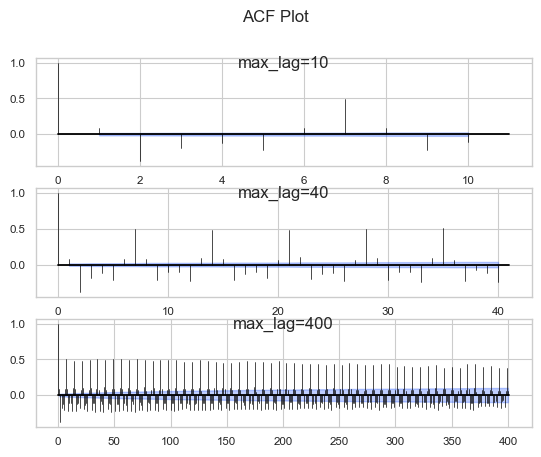

In [465]:
from darts.utils.statistics import plot_acf, check_seasonality

f, ax = plt.subplots(3, 1, sharey=True)

# for differnent number of lags
for i, n_lag in enumerate([10, 40, 400]):

    plot_acf(ts_demand_train_diff, max_lag=n_lag, alpha=0.5, fig_size=(12, 3), axis=ax[i])
    ax[i].set_title(f'max_lag={n_lag}', loc='center', pad=-7)

# add sup title
f.suptitle('ACF Plot')

#### Auto Correlation check
check seasonalty via darts' `check_seasonality` function. Results show seasonality of 7.

In [466]:
from darts.utils.statistics import check_seasonality

check_seasonality(ts_demand_train_diff, max_lag=400)

(True, 7)

reuslts show there is a seasonality of 7 days.

#### Summary
According to ACF plots and `check_seasonality`, we can find the correlation increases as we approach the cycle peaks, so there is seasonality in our time series.

### Heteroscedasticity
Heteroscedasticity in time series means the variability of series varies over the time. Models will perform worse on time series with heteroscedasticity, so checking is important to how to transform the data for the modelling part. When there is Heteroscedasticity, we should apply Box-Cox or log transformation.

Reference:
* [Introduction to Heteroscedasticity](https://timeseriesreasoning.com/contents/introduction-to-heteroscedasticity/)
* [Beyond QQ Plots: Tests for Heteroskedasticity in Python](https://medium.com/@remycanario17/tests-for-heteroskedasticity-in-python-208a0fdb04ab)

In [467]:
# import
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
import numpy as np

# take copy
data_test_hetero = pd.DataFrame(data_clean[['demand', 'time_period']].copy())

# take log-tranform
# data_test_hetero['log_demand'] = np.log(data_test_hetero.demand)

# view results
data_test_hetero.head()

,demand,time_period
Date,,
2015-01-01,99635.030,1
2015-01-02,129606.010,2
2015-01-03,142300.540,3
2015-01-04,104330.715,4
2015-01-05,118132.200,5


#### Run linear regression

In [30]:
# import
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [468]:
# fit regression
expr = 'demand ~ time_period'
ols_result = smf.ols(expr, data_test_hetero).fit()

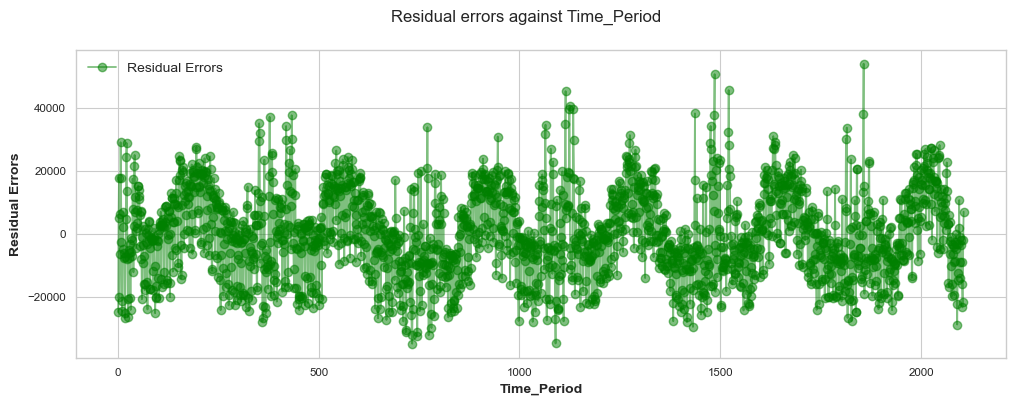

In [469]:
# plot residual
f, ax = plt.subplots(figsize=(12, 4))
ax.plot(data_test_hetero['time_period'], ols_result.resid, 'go-', label='Residual Errors', alpha=0.5)

#Set the title of the plot
f.suptitle('Residual errors against Time_Period')
ax.set_xlabel('Time_Period')
ax.set_ylabel('Residual Errors')
ax.legend()

#### White Test
Use White Test to detect heteroscedasticity.
null hypothesis: no heteroscedastisticity in the residual errors

In [470]:
# store in dataframe
from patsy import dmatrices

y_white_test, X_white_test = dmatrices(expr, data_test_hetero, return_type='dataframe')

In [471]:
keys = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
results = het_white(ols_result.resid, X_white_test)
lzip(keys, results)

[('Lagrange Multiplier statistic:', 0.5891321962312175),
 ("LM test's p-value:", 0.7448547112216335),
 ('F-statistic:', 0.29422879581856876),
 ("F-test's p-value:", 0.7451366622113536)]

#### Summary
According to white test results, we can reject null hypothesis, and the time series is Heteroscedasticity.

As a result, log transformation or Box-Cox transformation is required to remove Heteroscedasticity.


## Decomposition
Perform seasonality and trend decomposition to better understand the series.

### LOESS
Decompose with LOESS(locally estimated scatterplot smoothing).

Reference: [Seasonal-Trend decomposition using LOESS (STL)](https://www.statsmodels.org/devel/examples/notebooks/generated/stl_decomposition.html)

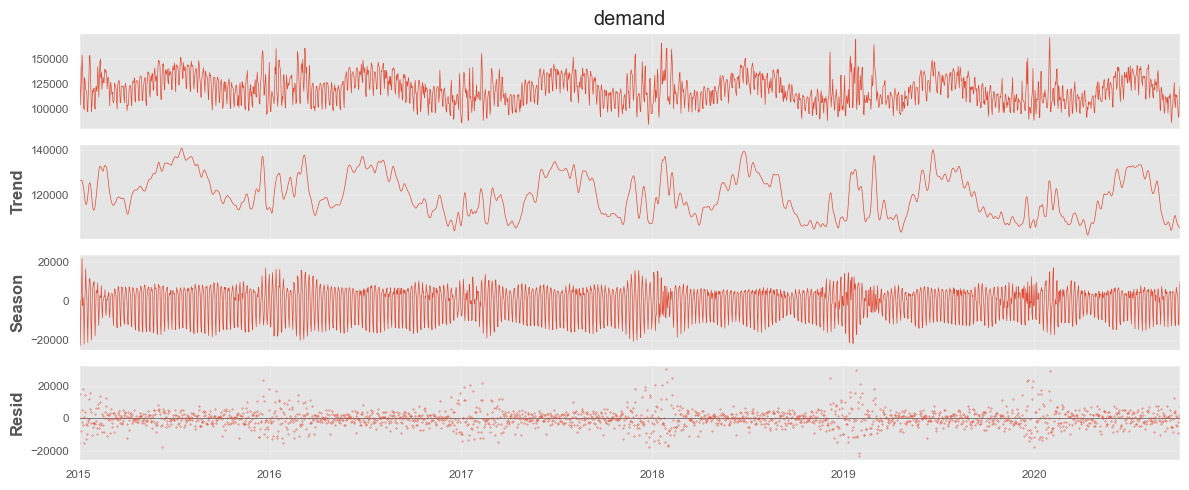

In [492]:
# decompose, with seasonal=7
from statsmodels.tsa.seasonal import STL

# adjust fig
plt.rc('figure', figsize=(12, 5))
plt.rc('font', size=10)
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['lines.markersize'] = 0.3


# plot
res = STL(data_clean.demand, seasonal=7).fit()
res.plot()
plt.show()

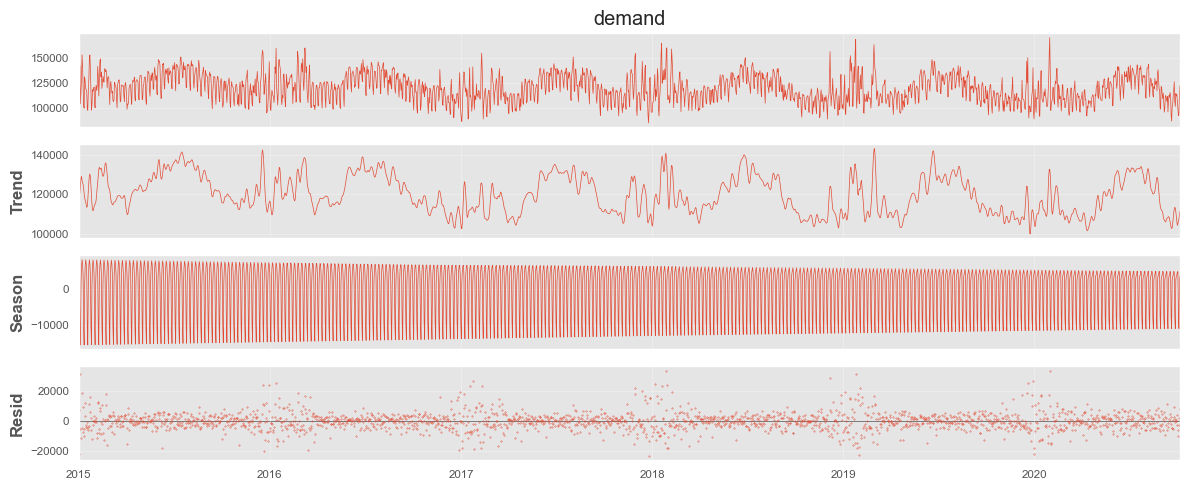

In [493]:
# decompose, with seasonal=365
from statsmodels.tsa.seasonal import STL

res = STL(data_clean.demand, seasonal=365).fit()
res.plot()
plt.show()

### MSTL
Multiple seasonality decomposition, where we can set multiple periods

reference: [MSTL applied to electricity demand dataset](https://www.statsmodels.org/devel/examples/notebooks/generated/mstl_decomposition.html#MSTL-applied-to-electricity-demand-dataset)

#### Decompose

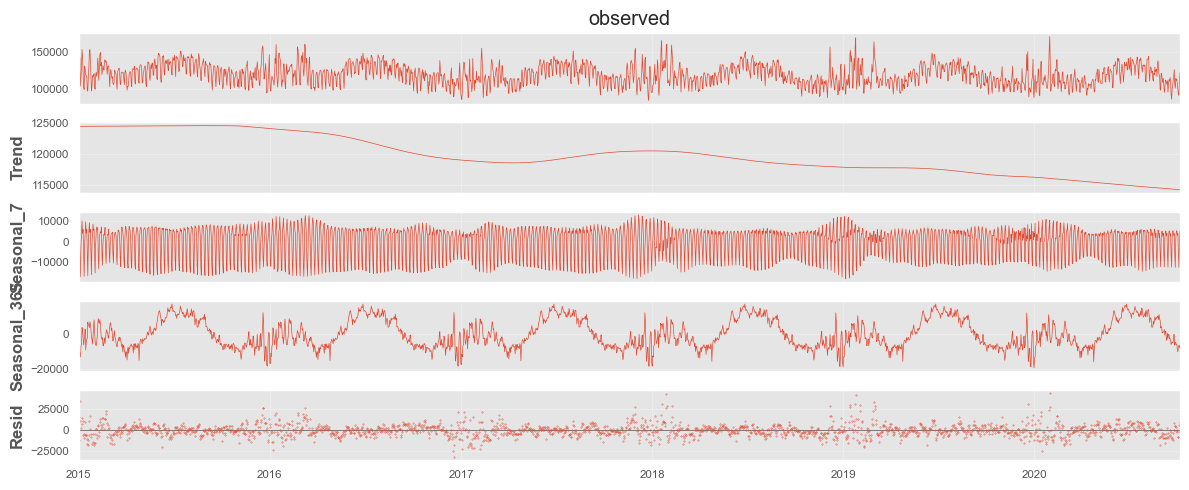

In [494]:
# decompose
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult

mstl = MSTL(data_clean.demand, periods=[7, 365], iterate=3, stl_kwargs={"seasonal_deg": 0,
                                                                          "inner_iter": 2,
                                                                          "outer_iter": 0})
res = mstl.fit()
ax = res.plot()
plt.tight_layout()

In [27]:
# view seasonal components
res.seasonal.head()

,seasonal_7,seasonal_365
Date,,
2015-01-01,4031.295422,-17080.027245
2015-01-02,5802.698178,-16704.466890
2015-01-03,-5767.428265,-10694.481395
2015-01-04,-17343.576358,-13290.241704
2015-01-05,-1917.230341,-6995.726372


#### View seasonality in detail

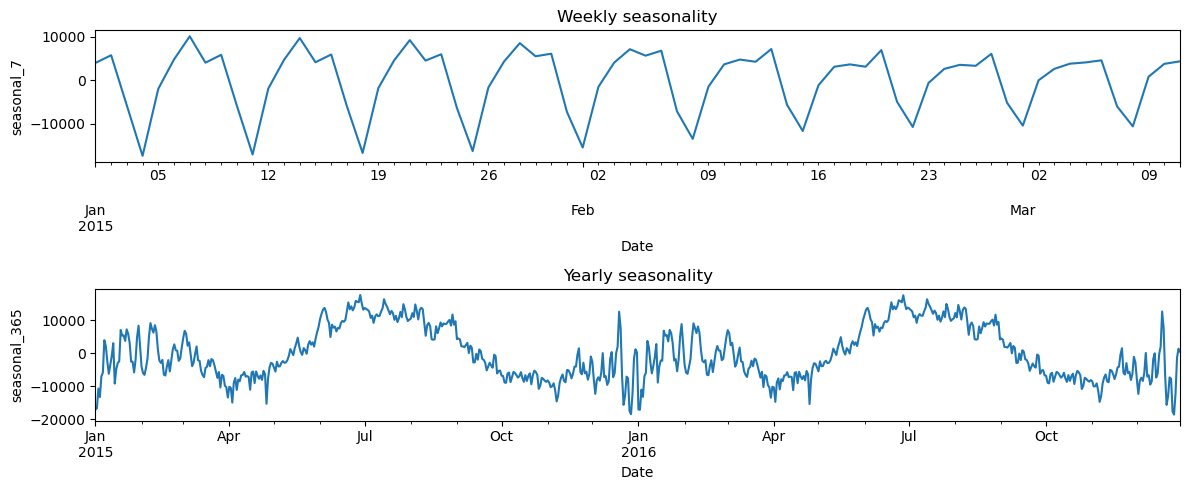

In [515]:
# view daily seasonality, take first 10 period

#%matplotlib inline

fig, ax = plt.subplots(nrows=2, figsize=[12,5])
res.seasonal["seasonal_7"].iloc[: 7*10].plot(ax=ax[0])
ax[0].set_ylabel("seasonal_7")
ax[0].set_title("Weekly seasonality")

# view yearly seasonality, take first 3 period
res.seasonal["seasonal_365"].iloc[: 2*365].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_365")
ax[1].set_title("Yearly seasonality")

plt.tight_layout()

### Metrics
The following metrics will be used for evaluation:
- Mean Squared Error(MSE)
- Mean Absolute Error(MAE)

More metrics to be considered:
- Time for fitting.
- Mean Absolute Percentage Error (MAPE). Note that it may raise error if $y_t=0$, so it is not used.


# Forecast with Statistical Models

## Data Transform
Transform data to be stationary series to achieve better results. Differencing and BoxCox Transformation are applied.

In [538]:
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import BoxCox

# build pipeline for y
scaler_y_stat = BoxCox(lmbda=0.2)

# fit and transform demand
ts_demand_train_stat = scaler_y_stat.fit_transform(ts_demand_train)

# transform validation and test
ts_demand_val_stat = scaler_y_stat.transform(ts_demand_val)
ts_demand_test_stat = scaler_y_stat.transform(ts_demand_test)

## Naive Baseline Model
A NaiveSeasonal(K) model always predict the value which occurred K time-stamps ago. It will be the baseline model.

Since the seasonality is tested to be 7, `k` will be set to 7.

There are some other Naive model to choose from, e.g.
- [Moving average forecast](https://unit8co.github.io/darts/generated_api/darts.models.filtering.moving_average_filter.html)
- Colletion of Naive model in darts: [Baseline Models](https://unit8co.github.io/darts/generated_api/darts.models.filtering.moving_average_filter.html0)

#### Fit

In [539]:
# predict with NaiveSeasonal
from darts.models import NaiveSeasonal

# fit
model_naive = NaiveSeasonal(K=7)
model_naive.fit(ts_demand_train_stat)

NaiveSeasonal(K=7)

In [592]:
# predict and score
pred_naive_val, score_naive_val = rolling_pred(true_y=ts_demand_val,
                                     true_y_transformed=ts_demand_val_stat,
                                     model=model_naive,
                                     transformer_y=scaler_y_stat,
                                     horizon=3,
                                     past_covariates=None,
                                     metric=[mse, mae])

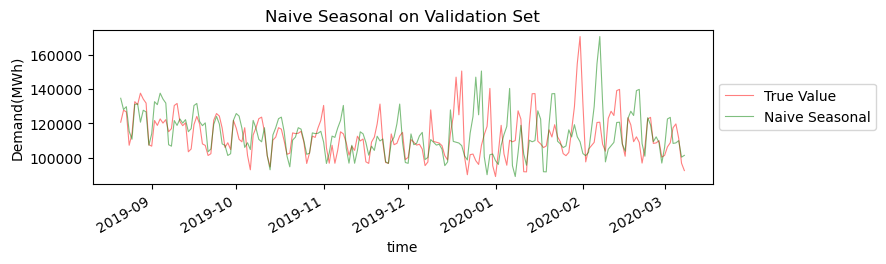

In [632]:
# plot prediction
plot_rolling_pred(true_value=ts_demand_val,
                    prediction=pred_naive_val,
                    name_model='Naive Seasonal',
                    name_set='Validation',
                    legend_out=True)

#### Evaluation

In [569]:
# create an empty dataframe to store all results
score_model = pd.DataFrame(index=['mse', 'mae'])

In [568]:
# view score
score_naive_val

array([2.1291283e+08, 1.0183510e+04], dtype=float32)

In [572]:
# add score metrics
score_model = add_score(score_dataframe=score_model,
                        name_model='naive',
                        score=score_naive_val)

score_model

,naive
mse,2.129128e+08
mae,1.018351e+04


## Fast Fourier Transform(FFT)
FFT is based upon Fourier Transformation. It decompose a series from time domain to frequency domain, and then tranform inversely back to time domain. By setting number of frequency to keep, we can actually exclude the noise away from our prediction.

Advantages:
- It suits seasonality series very well, since the original series is decomposed to sin and cos waves.
- It take much less time than model like ARIMA.

References:
- [FFT in darts](https://unit8co.github.io/darts/examples/03-FFT-examples.html?highlight=detrend#Improvement-3:-Detrending)
- [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform)

### Fit and Predict
best parameter choice:
- `nr_freqs_to_keep`: only keep 20 frequencies with the highest amplitudes
- `trend`: since ADF test shows it is stationary, we do not need to set any value for it.
- `required_matches`: match seasonality of series



In [575]:
from darts.models import FFT

# fit
model_fft = FFT(nr_freqs_to_keep=20, required_matches={'month'})
model_fft.fit(ts_demand_train_stat)

FFT(nr_freqs_to_keep=20, required_matches={'month'}, trend=None, trend_poly_degree=3)

In [594]:
# predict and score
pred_fft_val, score_fft_val = rolling_pred(true_y=ts_demand_val,
                                           true_y_transformed=ts_demand_train_stat.concatenate(ts_demand_val_stat),
                                           model=model_fft,
                                           transformer_y=scaler_y_stat,
                                           horizon=3,
                                           past_covariates=None,
                                           metric=[mse, mae],
                                           start=val_start)

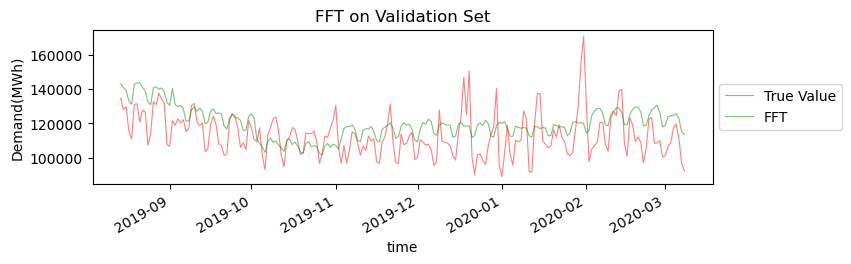

In [641]:
# plot prediction
plot_rolling_pred(true_value=ts_demand_val,
                    prediction=pred_fft_val,
                    name_model='FFT',
                    name_set='Validation',
                    legend_out=True)

### Evaluation

In [596]:
# view score
score_fft_val

array([1.80427404e+08, 1.11588840e+04])

In [597]:
# add score metrics
score_model = add_score(score_dataframe=score_model,
                        name_model='fft',
                        score=score_fft_val)

score_model

,naive,fft
mse,2.129128e+08,1.804274e+08
mae,1.018351e+04,1.115888e+04


## Auto-ARIMA
Auto-ARIMA select parameters (p, d, q, s) of ARIMA model automatically. A wrapper around [`pmdarima.arima.AutoARIMA`](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.AutoARIMA.html)

Note on ARIMA's parameter:
- `p`: number of previous timesteps of AR(p)
- `q`: number of timesteps in moving window of MA(q)
- `d`: order of difference to make series stationary
- `s`: order of seasonal component

References:
- [Tips to using `auto_arima`](https://alkaline-ml.com/pmdarima/tips_and_tricks.html#)

### Fit and Predict

In [658]:
from darts.models import AutoARIMA

# fit
model_arima = AutoARIMA(m=7, test='adf', d=1)
model_arima.fit(ts_demand_train_stat)

# predict
# forecast_arima = model_arima.predict(len(ts_demand_val))

AutoARIMA(add_encoders=None, m=7, test=adf, d=1)

In [ ]:
# predict and score
pred_arima_val, score_arima_val = rolling_pred(true_y=ts_demand_val,
                                               true_y_transformed=ts_demand_train_stat.concatenate(ts_demand_val_stat),
                                               model=model_arima,
                                               transformer_y=scaler_y_stat,
                                               horizon=3,
                                               past_covariates=None,
                                               metric=[mse, mae],
                                               start=val_start)

Error fitting  ARIMA(2,1,2)(2,0,2)[7] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "D:\program_location\program_code\Anaconda\envs\torch\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "D:\program_location\program_code\Anaconda\envs\torch\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "D:\program_location\program_code\Anaconda\envs\torch\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "D:\program_location\program_code\Anaconda\envs\torch\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "D:\program_location\program_code\Anaconda\envs\torch\Lib\site-packages\statsmodels\tsa\statespace\mle

KeyboardInterrupt: 

In [ ]:
# plot prediction
plot_rolling_pred(true_value=ts_demand_val,
                    prediction=pred_arima_val,
                    name_model='ARIMA',
                    name_set='Validation',
                    legend_out=True)

### Evaluation

In [596]:
# view score
score_arima_val

array([1.80427404e+08, 1.11588840e+04])

In [597]:
# add score metrics
score_model = add_score(score_dataframe=score_model,
                        name_model='arima',
                        score=score_arima_val)

score_model

,naive,fft
mse,2.129128e+08,1.804274e+08
mae,1.018351e+04,1.115888e+04


## Theta Model
Theta model reliles on parameter $\theta$, so the next part will firstly find out the optimal value of theta and then make prediction

### Select theta
select $\theta$ on 50 values and select theta based on MAE

In [600]:
from darts.models import Theta

# candidate values
theta_value = [2]

# initialize
best_mae = float("inf")
best_theta = 0
best_pred = None

# try all values
for theta in theta_value:
    model = Theta(theta, seasonality_period=7)
    model.fit(ts_demand_train)
    pred_theta = model.predict(len(ts_demand_val))
    mae_score = mae(ts_demand_val, pred_theta)

    # update for better value
    if mae_score < best_mae:
        best_mae = mae_score
        best_theta = theta
        best_pred = pred_theta

# view results
print(f'best theta: {theta}')

best theta: 2


Optimization failed to converge. Check mle_retvals.


In [601]:
# predict and score
pred_theta_val, score_theta_val = rolling_pred(true_y=ts_demand_val,
                                               true_y_transformed=ts_demand_train_stat.concatenate(ts_demand_val_stat),
                                               model=Theta(best_theta),
                                               transformer_y=scaler_y_stat,
                                               horizon=3,
                                               past_covariates=None,
                                               metric=[mse, mae],
                                               start=val_start)

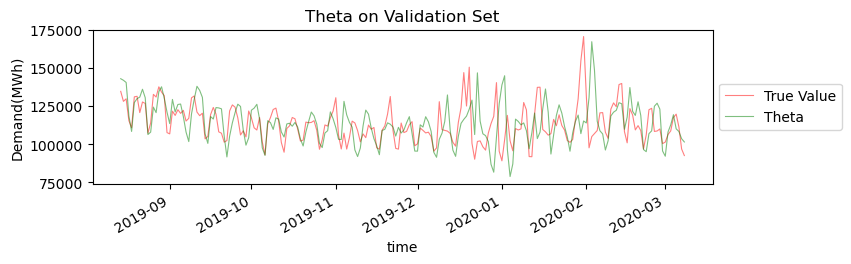

In [640]:
# plot prediction
plot_rolling_pred(true_value=ts_demand_val,
                    prediction=pred_theta_val,
                    name_model='Theta',
                    name_set='Validation',
                    legend_out=True)

### Evaluation

In [603]:
# view score
score_theta_val

array([2.20105055e+08, 1.04455722e+04])

In [604]:
# add score metrics
score_model = add_score(score_dataframe=score_model,
                        name_model='theta',
                        score=score_theta_val)

score_model

,naive,fft,theta
mse,2.129128e+08,1.804274e+08,2.201051e+08
mae,1.018351e+04,1.115888e+04,1.044557e+04


## TBD
1. ARIMA: select parameters of ARIMA with AIC
    reference:
    - sec. 6.4.2 of [Time Series Forecasting in Python](https://www.manning.com/books/time-series-forecasting-in-python-book)

2. cross-validation: use pmdarima for cv
    reference:
    - [Cross-validation predictions](https://alkaline-ml.com/pmdarima/auto_examples/model_selection/example_cross_val_predict.html#cross-validation-predictions)

# Forecast with ML Model

## Data Transform

### Scaling
Use sklearn's standard Scaling to transform demand and weather time series

Reference:
- [6.1.2. Transforming target in regression](https://scikit-learn.org/stable/modules/compose.html#transformed-target-regressor)

In [367]:
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import StandardScaler

# scaler for input variable
scaler_y = Scaler(scaler=StandardScaler())

# scaler for output variable(to be forceasted)
scaler_x = Scaler(scaler=StandardScaler())

# fit and transform on train data
ts_demand_train_scaled = scaler_y.fit_transform(ts_demand_train)
ts_weather_train_scaled = scaler_x.fit_transform(ts_weather_train)

# transform on validation and test data
ts_weather_val_scaled = scaler_x.transform(ts_weather_val)
ts_weather_test_scaled = scaler_x.transform(ts_weather_test)

# transform on y's validation and test data
ts_demand_val_scaled = scaler_y.transform(ts_demand_val)
ts_demand_test_scaled = scaler_y.transform(ts_demand_test)

In [311]:
# concatenate scaled train, val and test of weather as covariates
ts_weather_train_val_scaled = ts_weather_train_scaled.concatenate(ts_weather_val_scaled)
ts_weather_all_scaled = ts_weather_train_val_scaled.concatenate(ts_weather_test_scaled)

# check length
ts_weather_all_scaled.duration == ts_demand.duration

True

### View Results

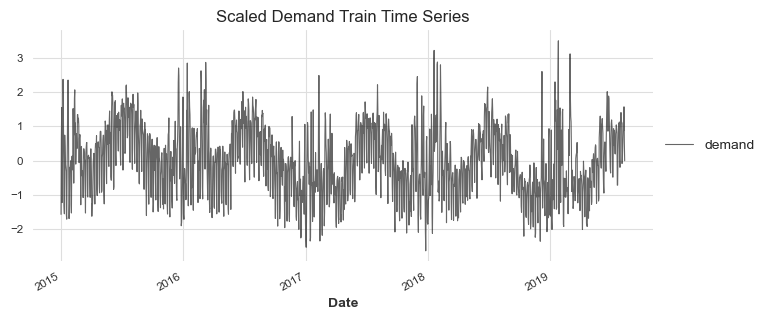

In [287]:
# view scaled energy demand

f, ax = plt.subplots(figsize=(10,3))
ts_demand_train_scaled.plot(ax=ax, alpha=0.6, linewidth=0.8)
ax.set_title('Scaled Demand Train Time Series')


# adjust legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

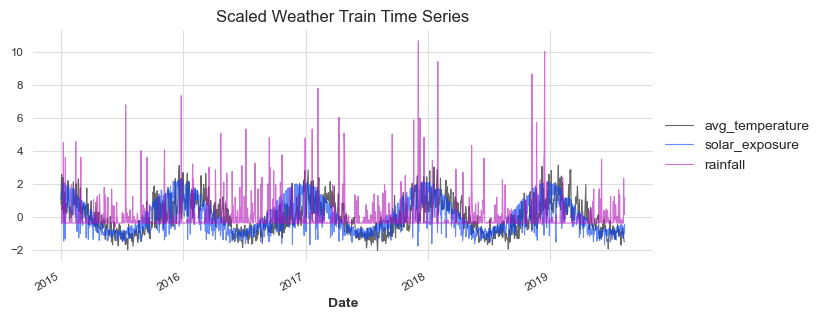

In [313]:
# view scaled weather

f, ax = plt.subplots(figsize=(10,3))
ts_weather_train_scaled.plot(ax=ax, alpha=0.6, linewidth=0.8)
ax.set_title('Scaled Weather Train Time Series')

# adjust legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Note on Forecasting with darts

Important darts references:
- [Data Pre-process](https://unit8co.github.io/darts/examples/02-data-processing.html)
- [Regression Models](https://unit8co.github.io/darts/examples/20-RegressionModel-examples.html)

Key idea
- [Rolling/Time series forecasting](https://tsfresh.readthedocs.io/en/latest/text/forecasting.html)
- `lags`, `lags_past_covariates`, `lags_future_covariates`
- `output_chunk_length`
- `past_covariates`, `future_covariates`
- `multi_model`

## Linear Regression
Apply linear regression for forecasting. The model is quite simple, but just to get familiar with using darts ML models.

### Fit

In [365]:
from darts.models import LinearRegressionModel

# temporal embeddings
encoders = {"datetime_attribute": {"past": ["month", "dayofweek"]}}

# fit to scaled data
model_lr = LinearRegressionModel(lags=30,
                                 lags_past_covariates=30,
                                 output_chunk_length=3,
                                 add_encoders=encoders)

model_lr.fit(ts_demand_train_scaled, past_covariates=ts_weather_train_scaled)

LinearRegressionModel(lags=30, lags_past_covariates=30, lags_future_covariates=None, output_chunk_length=3, add_encoders={'datetime_attribute': {'past': ['month', 'dayofweek']}}, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

### Evaluation

In [607]:
# predict and score
pred_lr_val, score_lr_val = rolling_pred(true_y=ts_demand_val,
                                         true_y_transformed=ts_demand_val_scaled,
                                         model=model_lr,
                                         transformer_y=scaler_y,
                                         horizon=3,
                                         past_covariates=ts_weather_all_scaled,
                                         metric=[mse, mae],
                                         refit=False)

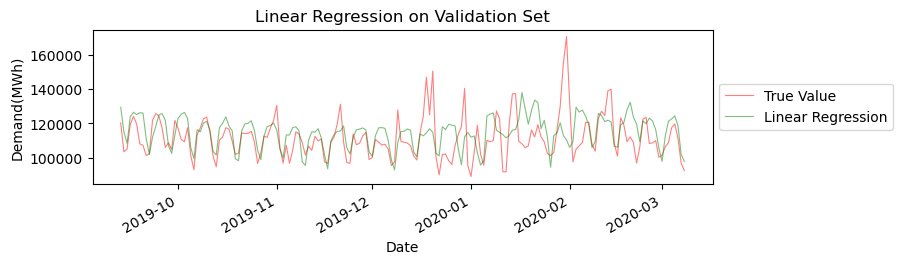

In [635]:
# plot prediction
plot_rolling_pred(true_value=ts_demand_val,
                  prediction=pred_lr_val,
                  name_model='Linear Regression',
                  name_set='Validation',
                  legend_out=True)

### Save Score
evaluate by backtesting on train set

In [609]:
# view score
score_lr_val

array([1.61097861e+08, 9.42676156e+03])

In [610]:
# add score metrics
score_model = add_score(score_dataframe=score_model,
                        name_model='lr',
                        score=score_lr_val)

score_model

,naive,fft,theta,lr
mse,2.129128e+08,1.804274e+08,2.201051e+08,1.610979e+08
mae,1.018351e+04,1.115888e+04,1.044557e+04,9.426762e+03


## XGBoost

### Fit

In [339]:
from darts.models import XGBModel

# fit
model_xgb = XGBModel(lags=30,
                     lags_past_covariates=30,
                     output_chunk_length=3,
                     add_encoders=encoders)

model_xgb.fit(ts_demand_train_scaled, past_covariates=ts_weather_train_scaled)

XGBModel(lags=30, lags_past_covariates=30, lags_future_covariates=None, output_chunk_length=3, add_encoders={'datetime_attribute': {'past': ['month', 'dayofweek']}}, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

### Evaluation

In [611]:
# predict and score
pred_xgb_val, score_xgb_val = rolling_pred(true_y=ts_demand_val,
                                         true_y_transformed=ts_demand_val_scaled,
                                         model=model_xgb,
                                         transformer_y=scaler_y,
                                         horizon=3,
                                         past_covariates=ts_weather_all_scaled,
                                         metric=[mse, mae],
                                         refit=False)

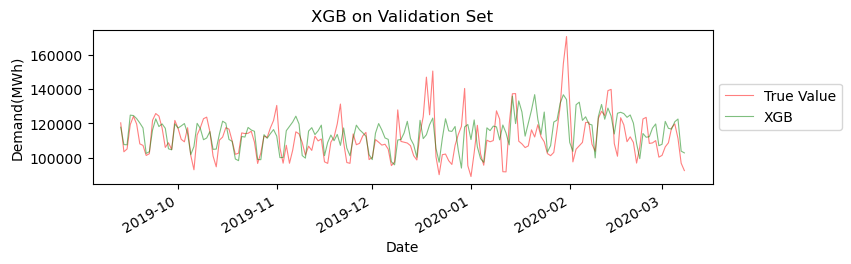

In [636]:
# plot prediction
plot_rolling_pred(true_value=ts_demand_val,
                  prediction=pred_xgb_val,
                  name_model='XGB',
                  name_set='Validation',
                  legend_out=True)

### Save Score

In [609]:
# view score
score_xgb_val

array([1.61097861e+08, 9.42676156e+03])

In [614]:
# add score metrics
score_model = add_score(score_dataframe=score_model,
                        name_model='xgb',
                        score=score_xgb_val)

score_model

,naive,fft,theta,lr,xgb
mse,2.129128e+08,1.804274e+08,2.201051e+08,1.610979e+08,1.289418e+08
mae,1.018351e+04,1.115888e+04,1.044557e+04,9.426762e+03,8.643609e+03


# Forecast with DL Model

References:
- [Torch Forecasting Models](https://unit8co.github.io/darts/userguide/torch_forecasting_models.html#top-level-look-at-training-and-predicting-with-chunks)
- [A review and comparison of strategies for multi-step ahead time series forecasting based on the NN5 forecasting competition](https://www.sciencedirect.com/science/article/abs/pii/S0957417412000528)

## LSTM
Two types of RNN model ind darts:
- RNN:
    - One prediction is made at one time
    - Auto-regressive prediction required when predict_horizon > 1
- Block RNN:
    - Support `output_chunk_length`>1
    - The model first encodes input, followed by FC layer and decoding.

References on LSTM:
- [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

### Fit

In [410]:
from darts.models import BlockRNNModel

model_brnn = BlockRNNModel(
    model="LSTM",
    input_chunk_length=7,
    output_chunk_length=3,
    batch_size=32,
    n_epochs=100,
    dropout=0.1,
    optimizer_kwargs={"lr": 1e-3},
    n_rnn_layers=2,
    random_state=42,
    force_reset=True,
)

model_brnn.fit(series=ts_demand_val_scaled,
               val_series=ts_demand_val_scaled,
               verbose=False,
               past_covariates=ts_weather_all_scaled,
               val_past_covariates=ts_weather_all_scaled)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.


BlockRNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.1, input_chunk_length=7, output_chunk_length=3, batch_size=32, n_epochs=100, optimizer_kwargs={'lr': 0.001}, random_state=42, force_reset=True)

### Evaluation

In [615]:
# predict and score
pred_brnn_val, score_brnn_val = rolling_pred(true_y=ts_demand_val,
                                         true_y_transformed=ts_demand_val_scaled,
                                         model=model_brnn,
                                         transformer_y=scaler_y,
                                         horizon=3,
                                         past_covariates=ts_weather_all_scaled,
                                         metric=[mse, mae],
                                         refit=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


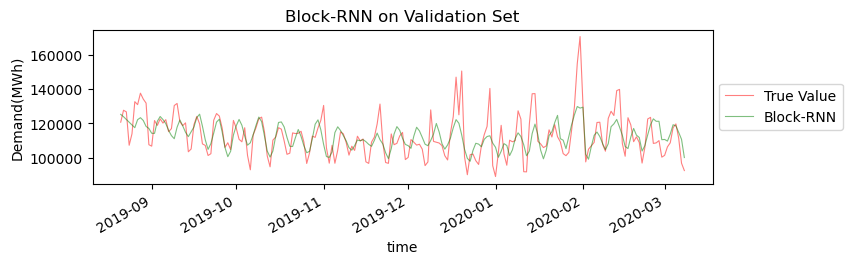

In [637]:
# plot prediction
plot_rolling_pred(true_value=ts_demand_val,
                  prediction=pred_brnn_val,
                  name_model='Block-RNN',
                  name_set='Validation',
                  legend_out=True)

### Save Score

In [617]:
# view score
score_brnn_val

array([9.25319998e+07, 7.15747190e+03])

In [618]:
# add score metrics
score_model = add_score(score_dataframe=score_model,
                        name_model='brnn',
                        score=score_brnn_val)

score_model

,naive,fft,theta,lr,xgb,brnn
mse,2.129128e+08,1.804274e+08,2.201051e+08,1.610979e+08,1.289418e+08,9.253200e+07
mae,1.018351e+04,1.115888e+04,1.044557e+04,9.426762e+03,8.643609e+03,7.157472e+03


## N-BEATS
The main advantages of N-BEATS is that it is interpretable in terms of seasonality and trend. Forecasts on both trend and seasonality are available.

Setting `generic_architecture=False` will lead to interpretable architecture as propsed in [N-BEATS: Neural basis expansion analysis for interpretable time series forecasting](https://arxiv.org/pdf/1905.10437.pdf)


### Fit
We set `input_chunk_length` to 7 mainly due to computation limitations, in contrast with 30 which is used in ML Model.

In [420]:
from darts.models import NBEATSModel

model_nbeats = NBEATSModel(input_chunk_length=7,
                           output_chunk_length=3,
                           n_epochs=100,
                           random_state=42,
                           generic_architecture=False)

model_nbeats.fit(series=ts_demand_val_scaled,
                 past_covariates=ts_weather_all_scaled,
                 val_series=ts_demand_val_scaled,
                 val_past_covariates=ts_weather_all_scaled,
                 verbose=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.


NBEATSModel(generic_architecture=False, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=7, output_chunk_length=3, n_epochs=100, random_state=42)

### Evaluation

In [620]:
# predict and score
pred_nbeats_val, score_nbeats_val = rolling_pred(true_y=ts_demand_val,
                                                 true_y_transformed=ts_demand_val_scaled,
                                                 model=model_nbeats,
                                                 transformer_y=scaler_y,
                                                 horizon=3,
                                                 past_covariates=ts_weather_all_scaled,
                                                 metric=[mse, mae],
                                                 refit=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


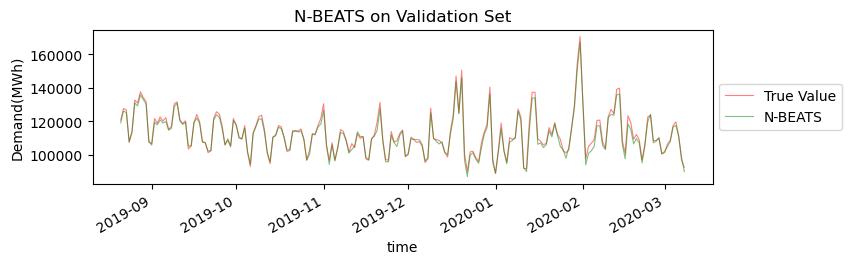

In [631]:
# plot prediction
plot_rolling_pred(true_value=ts_demand_val,
                  prediction=pred_nbeats_val,
                  name_model='N-BEATS',
                  name_set='Validation',
                  legend_out=True)

### Save Score

In [638]:
# view score
score_nbeats_val

array([3.77106052e+06, 1.54826967e+03])

In [639]:
# add score metrics
score_model = add_score(score_dataframe=score_model,
                        name_model='nbeats',
                        score=score_nbeats_val)

score_model

,naive,fft,theta,lr,xgb,brnn,nbeats
mse,2.129128e+08,1.804274e+08,2.201051e+08,1.610979e+08,1.289418e+08,9.253200e+07,3.771061e+06
mae,1.018351e+04,1.115888e+04,1.044557e+04,9.426762e+03,8.643609e+03,7.157472e+03,1.548270e+03


### Explain

In [ ]:
from darts.explainability.explainability_result import Somce

explainer_nbeats = ComponentBasedExplainabilityResult

## TCN
TCN is an adaption of CNN for forecasting with following advantages:
- Filter layer make parallel processing possible, so much faster than RNN, especially for large time series.
- Avoide gradient explosion and vanishing problem.
- Kernel size can adjust the input length to network.

Reference:
- https://zhuanlan.zhihu.com/p/269731045
- [Temporal Convolutional Networks and Forecasting](https://unit8.com/resources/temporal-convolutional-networks-and-forecasting/)
- [Hyper-parameters Optimization for Electricity Load Forecasting](https://unit8co.github.io/darts/examples/17-hyperparameter-optimization.html)

### Fit
First using default parameters

In [430]:
from darts.models import TCNModel

# train
model_tcn = TCNModel(
    input_chunk_length=7,
    output_chunk_length=3)

model_tcn.fit(series=ts_demand_val_scaled,
              past_covariates=ts_weather_all_scaled,
              val_series=ts_demand_val_scaled,
              val_past_covariates=ts_weather_all_scaled,
              verbose=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.


TCNModel(kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.2, input_chunk_length=7, output_chunk_length=3)

### Evaluation

In [642]:
# predict and score
pred_tcn_val, score_tcn_val = rolling_pred(true_y=ts_demand_val,
                                           true_y_transformed=ts_demand_val_scaled,
                                           model=model_tcn,
                                           transformer_y=scaler_y,
                                           horizon=3,
                                           past_covariates=ts_weather_all_scaled,
                                           metric=[mse, mae],
                                           refit=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


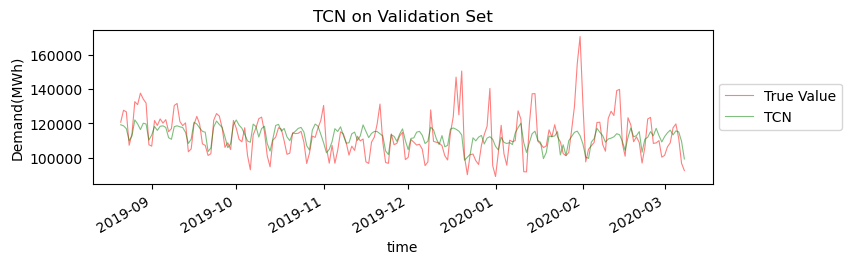

In [643]:
# plot prediction
plot_rolling_pred(true_value=ts_demand_val,
                  prediction=pred_tcn_val,
                  name_model='TCN',
                  name_set='Validation',
                  legend_out=True)

### Save Score

In [645]:
# view score
score_tcn_val

array([1.10933006e+08, 7.48294359e+03])

In [646]:
# add score metrics
score_model = add_score(score_dataframe=score_model,
                        name_model='tcn',
                        score=score_tcn_val)

score_model

,naive,fft,theta,lr,xgb,brnn,nbeats,tcn
mse,2.129128e+08,1.804274e+08,2.201051e+08,1.610979e+08,1.289418e+08,9.253200e+07,3.771061e+06,1.109330e+08
mae,1.018351e+04,1.115888e+04,1.044557e+04,9.426762e+03,8.643609e+03,7.157472e+03,1.548270e+03,7.482944e+03


## Tunning with Optuna
Tune hyper-parameter with Optuna and monitor progress with pytorch_lightning
Note:
- Use `pip install pytorch-lightning==1.7.7` to avoid conflicts between Optuna and pytorch-lightning.

Reference:
- [Callback for Study.optimize](https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/007_optuna_callback.html#optuna-callback)
- [Quick Visualization for Hyperparameter Optimization Analysis](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#visualization)

### Create Study

In [655]:
# beyas search

from pytorch_lightning.callbacks import Callback, EarlyStopping
import optuna
from optuna.integration import PyTorchLightningPruningCallback
import torch


# define objective function
def objective(trial):

    # hyperparameter range
    input_trial = trial.suggest_int("x_len", 7, 14)     # input chunk size
    kernel_trial = trial.suggest_int("kernel_size", 2, 5)
    filter_trial = trial.suggest_int("filter_num", 1, 4)
    dropout_trial = trial.suggest_float("dropout_rate", 0, 0.3)
    lr_trial = trial.suggest_float("lr", 1e-5, 1e-3, log=True)

    # monitor progress
    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping("val_loss",
                                  min_delta=1e-3,
                                  patience=4,
                                  verbose=True)
    callback_out = [pruner, early_stopper]

    # random seed
    torch.manual_seed(42)

    # create model
    model = TCNModel(
        input_chunk_length=input_trial,
        output_chunk_length=3,
        kernel_size=kernel_trial,
        num_filters=filter_trial,
        dropout=dropout_trial,
        optimizer_kwargs={"lr": lr_trial},
        model_name="tcn_model",
        pl_trainer_kwargs={"callbacks": callback_out},
        save_checkpoints=True,
        force_reset=True)


    # train
    model.fit(
        series=ts_demand_val_scaled,
        past_covariates=ts_weather_all_scaled,
        val_series=ts_demand_val_scaled,
        val_past_covariates=ts_weather_all_scaled,
        verbose=False
    )

    # get best model
    model_best = TCNModel.load_from_checkpoint("tcn_model")

    # evaluate the model by rolling window predict on val set, use mae as metric
    _, score_tcn_tune_val = rolling_pred(true_y=ts_demand_val,
                                         true_y_transformed=ts_demand_val_scaled,
                                         model=model,
                                         transformer_y=scaler_y,
                                         horizon=3,
                                         past_covariates=ts_weather_all_scaled,
                                         metric=mae,
                                         refit=False)

    # get the value in results
    score = score_tcn_tune_val.item()

    # avoid nan
    score = score if score != np.nan else float("inf")

    return score

# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

# create study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2023-12-05 14:43:53,295] A new study created in memory with name: no-name-696d33e0-60be-41d0-9dc2-c1a9f7ab6353
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Metric val_loss improved. New best score: 2.353
Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 2.343
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 2.336
Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 2.310
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 2.304
Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 2.278
Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 2.263
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 2.255
Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 2.242
Metric val_loss improved by 0.015 >= min_delta = 0.001. New best sc

### Results

In [656]:
study.best_trial

FrozenTrial(number=4, state=1, values=[7098.828388689303], datetime_start=datetime.datetime(2023, 12, 5, 14, 44, 12, 732407), datetime_complete=datetime.datetime(2023, 12, 5, 14, 44, 22, 72210), params={'x_len': 13, 'kernel_size': 2, 'filter_num': 4, 'dropout_rate': 0.0031502791052430367, 'lr': 0.0007343623795529059}, user_attrs={}, system_attrs={}, intermediate_values={0: 1.419612940363945, 1: 1.3803486215935366, 2: 1.332016539327273, 3: 1.2944692104902709, 4: 1.2622601340248847, 5: 1.2254656435582736, 6: 1.1924562183039096, 7: 1.1649174274503133, 8: 1.134451354347379, 9: 1.109461742459678, 10: 1.0833706630260558, 11: 1.0582897477170812, 12: 1.0381782998020141, 13: 1.0199591867607676, 14: 0.9962780451342805, 15: 0.9790849991140814, 16: 0.9619570477761316, 17: 0.9379490383542616, 18: 0.9228027663454679, 19: 0.9051602739452815, 20: 0.8950681765958997, 21: 0.8785471291582181, 22: 0.8677165031395238, 23: 0.8551841230080123, 24: 0.8434834424341462, 25: 0.8342933419661026, 26: 0.82410436652

View as dataframe

In [660]:
study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))

,number,value,params_dropout_rate,params_filter_num,params_kernel_size,params_lr,params_x_len,state
0,0,14170.623528,0.136023,1,3,0.000111,9,COMPLETE
1,1,10615.422051,0.259801,2,4,0.000207,12,COMPLETE
2,2,11402.756541,0.146246,4,4,0.000032,11,COMPLETE
3,3,10256.857320,0.266114,3,2,0.000272,9,COMPLETE
4,4,7098.828389,0.003150,4,2,0.000734,13,COMPLETE
5,5,10504.210937,0.084673,1,2,0.000246,13,COMPLETE
6,6,2.472999,0.096887,4,2,0.000552,8,PRUNED
7,7,10118.010584,0.147468,2,4,0.000139,13,COMPLETE
8,8,9067.096867,0.196754,1,4,0.000812,12,COMPLETE
9,9,1.575650,0.128567,1,5,0.000010,12,PRUNED


In [670]:
study.best_value

7098.828388689303

### Visualize

View Loss History

In [663]:
optuna.visualization.plot_optimization_history(study)

Hyperparameter Importance

In [664]:
optuna.visualization.plot_param_importances(study)

View in Contour

In [666]:
optuna.visualization.plot_contour(study, params=['lr', 'dropout_rate'])

Relation between Parameters

In [669]:
optuna.visualization.plot_rank(study, params=['lr', 'dropout_rate', 'x_len'])

C:\Users\ymw13\AppData\Local\Temp\ipykernel_13740\2527050340.py:1: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



# TBD
- Implementation
    - rolling predict length
    - lagging and feature extraction
    - Pytorch for deepl learning model, e.g. RNN as encoder and decoder
    - Try Tefresh
- Run on test set
- Model
    - Error with ARIMA
    - Attention Model and Transformers
    - Explain N-BEATS results
- Tunning parameter on larger range of values
- More covariates as input